In [ ]:

# ADIM 1: FIREBASE KURULUMU


!pip install requests pandas numpy matplotlib seaborn scikit-learn -q

import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json


# Firebase URL
FIREBASE_URL = "https://smartbinproject-45fe5-default-rtdb.firebaseio.com"

print(f" Firebase URL: {FIREBASE_URL}")

 Firebase URL: https://smartbinproject-45fe5-default-rtdb.firebaseio.com


In [ ]:


# DEBUG MODU VE YARDIMCI FONKSİYONLAR


DEBUG = True  # False yaparsanız debug mesajları kapanır

def debug_print(mesaj):
    """Debug mesajı yazdır"""
    if DEBUG:
        print(f"🐛 DEBUG: {mesaj}")

def veri_kontrol(df, fonksiyon_adi=""):
    """DataFrame'i kontrol et"""
    print(f"\n🔍 VERİ KONTROLÜ: {fonksiyon_adi}")

    if df is None:
        print("   ❌ DataFrame None!")
        return False

    print(f"   📊 Kayıt sayısı: {len(df)}")
    print(f"   📋 Sütunlar: {list(df.columns)[:5]}...")  # İlk 5 sütun
    print(f"   ⚠️ Boş değer: {df.isnull().sum().sum()} adet")

    if len(df) > 0:
        print(f"   📈 Son doluluk: %{df.iloc[-1]['doluluk']:.1f}")
        print(f"   🎨 Durum: {df.iloc[-1]['durum']}")
    else:
        print("   ❌ DataFrame boş!")
        return False

    return True

# Hata log sistemi
hata_log = []

def hata_kaydet(hata_mesaji, hata_tipi="Genel", detay=None):
    """Hataları kaydet"""
    kayit = {
        'zaman': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'tip': hata_tipi,
        'mesaj': str(hata_mesaji),
        'detay': str(detay) if detay else None
    }
    hata_log.append(kayit)
    print(f"❌ HATA KAYDEDILDI: [{hata_tipi}] {hata_mesaji}")

print("✅ Debug sistemi hazır!")

✅ Debug sistemi hazır!


In [ ]:
# ═══════════════════════════════════════════════════════════════════
# ADIM 2: SADECE FIREBASE VERİSİ (BACKEND UYUMLU)
# ═══════════════════════════════════════════════════════════════════

import requests
import pandas as pd
from datetime import datetime, timedelta

# Firebase URL
FIREBASE_URL = "https://smartbinproject-45fe5-default-rtdb.firebaseio.com"

def firebase_veri_cek():
    """Firebase'den veri çek"""
    debug_print("Firebase'den veri çekiliyor...")

    print("Firebase'den veriler çekiliyor...\n")

    # 1. ANLIK VERİYİ ÇEK
    print("📡 Anlık veri çekiliyor...")
    url_live = f"{FIREBASE_URL}/cop_kutusu_1/live_data.json"

    try:
        response_live = requests.get(url_live, timeout=10)
        debug_print(f"Anlık veri yanıt kodu: {response_live.status_code}")

        if response_live.status_code == 200:
            anlik_veri = response_live.json()
            debug_print(f"Anlık veri içeriği: {anlik_veri}")
            print("✅ Anlık veri alındı:")
            print(f"   Doluluk: %{anlik_veri.get('doluluk', 'N/A')}")
            print(f"   Durum: {anlik_veri.get('durum', 'N/A')}\n")
        else:
            anlik_veri = None
            hata_kaydet(f"Anlık veri HTTP {response_live.status_code}", "Firebase")
            print("⚠️ Anlık veri alınamadı!\n")
    except Exception as e:
        anlik_veri = None
        hata_kaydet(f"Anlık veri hatası: {e}", "Firebase Bağlantı")
        print(f"❌ Bağlantı hatası: {e}\n")

    # 2. GEÇMİŞ LOGLARI ÇEK
    print("📜 Geçmiş loglar çekiliyor...")
    url_logs = f"{FIREBASE_URL}/cop_kutusu_1/logs.json"

    try:
        response_logs = requests.get(url_logs, timeout=10)
        debug_print(f"Log yanıt kodu: {response_logs.status_code}")

        if response_logs.status_code == 200 and response_logs.json():
            logs = response_logs.json()
            debug_print(f"Log sayısı: {len(logs)}")
            print(f"✅ {len(logs)} adet log bulundu!\n")

            # DataFrame'e çevir
            log_list = []
            basarili = 0
            basarisiz = 0

            for log_key, veri in logs.items():
                try:
                    esp_timestamp = int(veri.get('timestamp', 0))

                    # Timestamp hesapla
                    if anlik_veri:
                        son_timestamp = anlik_veri.get('timestamp', 0)
                        gecmis_saniye = son_timestamp - esp_timestamp
                        gercek_zaman = datetime.now() - timedelta(seconds=gecmis_saniye)
                    else:
                        gercek_zaman = datetime.now() - timedelta(seconds=int(log_key)//1000)

                    log_list.append({
                        'timestamp': gercek_zaman,
                        'cop_kutusu_id': 1,
                        'doluluk': float(veri.get('doluluk', 0)),
                        'mesafe_cm': float(veri.get('mesafe_cm', 0)),
                        'firebase_durum': veri.get('durum', 'UNKNOWN')
                    })
                    basarili += 1
                except Exception as e:
                    basarisiz += 1
                    debug_print(f"Log parse hatası [{log_key}]: {e}")
                    continue

            debug_print(f"Başarılı: {basarili}, Başarısız: {basarisiz}")

            if len(log_list) == 0:
                hata_kaydet("Log parse edilemedi", "Veri İşleme")
                print("❌ Hiçbir log parse edilemedi!\n")
                return None, anlik_veri

            df_firebase = pd.DataFrame(log_list)
            df_firebase = df_firebase.sort_values('timestamp').reset_index(drop=True)

            return df_firebase, anlik_veri
        else:
            print("⚠️ Log verisi yok!\n")
            hata_kaydet("Log verisi bulunamadı", "Firebase")
            return None, anlik_veri
    except Exception as e:
        hata_kaydet(f"Log çekme hatası: {e}", "Firebase Bağlantı")
        print(f"❌ Log hatası: {e}\n")
        return None, anlik_veri


def sadece_firebase_veri_hazirla():
    """Sadece Firebase verisini kullan"""
    print("="*70)
    print("🔥 SADECE FIREBASE VERİSİ KULLANILIYOR (BACKEND UYUMLU)")
    print("="*70)
    print()

    # Firebase'den veri çek
    df_firebase, anlik_veri = firebase_veri_cek()

    if df_firebase is None or len(df_firebase) == 0:
        print("❌ Firebase'de veri yok!")
        return None, None

    firebase_kayit = len(df_firebase)
    print(f"📊 Firebase: {firebase_kayit} kayıt bulundu")
    print(f"🚫 Simülasyon kullanılmıyor - SADECE GERÇEK VERİ!\n")

    # Sadece Firebase verisi
    df = df_firebase.copy()

    # VERİYİ HAZIRLAMA (Özellik Mühendisliği)
    print("🔧 Özellikler ekleniyor...")

    # Zaman özellikleri
    df['saat'] = df['timestamp'].dt.hour
    df['dakika'] = df['timestamp'].dt.minute
    df['gun'] = df['timestamp'].dt.day
    df['hafta_gunu'] = df['timestamp'].dt.dayofweek
    df['hafta_ici'] = df['hafta_gunu'].apply(lambda x: 1 if x < 5 else 0)

    # Gün dilimi
    def gun_dilimi(saat):
        if 6 <= saat < 12: return 'Sabah'
        elif 12 <= saat < 18: return 'Öğle'
        elif 18 <= saat < 24: return 'Akşam'
        else: return 'Gece'

    df['gun_dilimi'] = df['saat'].apply(gun_dilimi)

    # ═══════════════════════════════════════════════════════════════
    # BACKEND UYUMLU DURUM BELİRLEME
    # Backend: 0-50% Yeşil, 50-80% Sarı, 80-100% Kırmızı
    # ═══════════════════════════════════════════════════════════════
    def durum_belirle(oran):
        if oran < 50: return 'Yeşil'
        elif oran < 80: return 'Sarı'
        else: return 'Kırmızı'

    df['durum'] = df['doluluk'].apply(durum_belirle)

    # Dolma hızı (güvenli versiyon)
    debug_print(f"Dolma hızı hesaplanıyor... Kayıt sayısı: {len(df)}")
    if len(df) > 1:
        try:
            df['dolma_hizi'] = df['doluluk'].diff().fillna(0)
            debug_print("✅ Dolma hızı başarıyla hesaplandı")
        except Exception as e:
            hata_kaydet(f"Dolma hızı hatası: {e}", "Veri İşleme")
            df['dolma_hizi'] = 0
    else:
        df['dolma_hizi'] = 0
        debug_print("⚠️ Tek kayıt var, dolma hızı 0 olarak ayarlandı")

    # Zaman farkı (güvenli versiyon)
    if len(df) > 1:
        try:
            df['zaman_farki'] = df['timestamp'].diff().dt.total_seconds() / 3600
            df['zaman_farki'] = df['zaman_farki'].fillna(0)
            debug_print("✅ Zaman farkı başarıyla hesaplandı")
        except Exception as e:
            hata_kaydet(f"Zaman farkı hatası: {e}", "Veri İşleme")
            df['zaman_farki'] = 0
    else:
        df['zaman_farki'] = 0
        debug_print("⚠️ Tek kayıt var, zaman farkı 0 olarak ayarlandı")

    # Boşaltma tespiti
    try:
        df['bosaltma'] = (df['dolma_hizi'] < -30).astype(int)
        debug_print("✅ Boşaltma tespiti yapıldı")
    except Exception as e:
        hata_kaydet(f"Boşaltma tespiti hatası: {e}", "Veri İşleme")
        df['bosaltma'] = 0

    # SONUÇLARI GÖSTER
    print("\n" + "="*70)
    print("✅ VERİ HAZIR!")
    print("="*70)
    print(f"📊 Toplam kayıt: {len(df)}")
    print(f"📅 Tarih aralığı: {df['timestamp'].min().strftime('%Y-%m-%d %H:%M')} → {df['timestamp'].max().strftime('%Y-%m-%d %H:%M')}")
    print(f"📈 Ortalama doluluk: %{df['doluluk'].mean():.1f}")
    print(f"🔺 Max doluluk: %{df['doluluk'].max():.1f}")
    print(f"🔻 Min doluluk: %{df['doluluk'].min():.1f}")

    # ═══════════════════════════════════════════════════════════════
    # BACKEND UYUMLU DURUM DAĞILIMI
    # ═══════════════════════════════════════════════════════════════
    print(f"\n🎨 Durum Dağılımı (BACKEND UYUMLU):")

    # Yeşil (0-50%)
    yesil_oran = len(df[df['doluluk'] < 50])
    print(f"   🟢 Yeşil (0-50%): {yesil_oran} ({yesil_oran/len(df)*100:.1f}%)")

    # Sarı (50-80%)
    sari_oran = len(df[(df['doluluk'] >= 50) & (df['doluluk'] < 80)])
    print(f"   🟡 Sarı (50-80%): {sari_oran} ({sari_oran/len(df)*100:.1f}%)")

    # Kırmızı (80-100%)
    kirmizi_oran = len(df[df['doluluk'] >= 80])
    print(f"   🔴 Kırmızı (80-100%): {kirmizi_oran} ({kirmizi_oran/len(df)*100:.1f}%)")

    # Boşaltma sayısı
    bosaltma_sayisi = df['bosaltma'].sum()
    print(f"\n🗑️ Boşaltma sayısı: {bosaltma_sayisi}")
    print("="*70)

    # CSV kaydet
    try:
        df.to_csv('sadece_firebase_veri.csv', index=False)
        print("\n✅ CSV kaydedildi: sadece_firebase_veri.csv\n")
    except Exception as e:
        hata_kaydet(f"CSV kaydetme hatası: {e}", "Dosya İşlemi")
        print(f"\n⚠️ CSV kaydedilemedi: {e}\n")

    return df, anlik_veri


# VERİYİ OLUŞTUR
print("🚀 Veri hazırlama başlıyor...\n")

df, anlik_veri = sadece_firebase_veri_hazirla()

if df is not None and len(df) > 0:
    print("="*70)
    print("✅ SADECE FIREBASE VERİSİ HAZIR!")
    print("="*70)

    print("\n📋 İlk 5 satır:")
    display(df[['timestamp', 'doluluk', 'mesafe_cm', 'durum', 'dolma_hizi']].head())

    print("\n📋 Son 5 satır:")
    display(df[['timestamp', 'doluluk', 'mesafe_cm', 'durum', 'dolma_hizi']].tail())

    print("\n✅ Artık analizlere başlayabilirsin!")

    # Veri kontrolü
    veri_kontrol(df, "ADIM 2 Sonucu")
else:
    print("="*70)
    print("❌ VERİ OLUŞTURULAMADI!")
    print("="*70)
    print("\n💡 Kontrol edilecekler:")
    print("   1. ESP32 çalışıyor mu?")
    print("   2. Firebase'e veri gönderiliyor mu?")
    print("   3. İnternet bağlantısı var mı?")

🚀 Veri hazırlama başlıyor...

🔥 SADECE FIREBASE VERİSİ KULLANILIYOR (BACKEND UYUMLU)

🐛 DEBUG: Firebase'den veri çekiliyor...
Firebase'den veriler çekiliyor...

📡 Anlık veri çekiliyor...
🐛 DEBUG: Anlık veri yanıt kodu: 200
🐛 DEBUG: Anlık veri içeriği: {'doluluk': 30, 'durum': 'NORMAL', 'mesafe_cm': 21, 'timestamp': 5996}
✅ Anlık veri alındı:
   Doluluk: %30
   Durum: NORMAL

📜 Geçmiş loglar çekiliyor...
🐛 DEBUG: Log yanıt kodu: 200
🐛 DEBUG: Log sayısı: 780
✅ 780 adet log bulundu!

🐛 DEBUG: Başarılı: 780, Başarısız: 0
📊 Firebase: 780 kayıt bulundu
🚫 Simülasyon kullanılmıyor - SADECE GERÇEK VERİ!

🔧 Özellikler ekleniyor...
🐛 DEBUG: Dolma hızı hesaplanıyor... Kayıt sayısı: 780
🐛 DEBUG: ✅ Dolma hızı başarıyla hesaplandı
🐛 DEBUG: ✅ Zaman farkı başarıyla hesaplandı
🐛 DEBUG: ✅ Boşaltma tespiti yapıldı

✅ VERİ HAZIR!
📊 Toplam kayıt: 780
📅 Tarih aralığı: 2025-12-05 05:05 → 2025-12-05 06:45
📈 Ortalama doluluk: %38.2
🔺 Max doluluk: %96.0
🔻 Min doluluk: %0.0

🎨 Durum Dağılımı (BACKEND UYUMLU):
   

,timestamp,doluluk,mesafe_cm,durum,dolma_hizi
0,2025-12-05 05:05:31.733370,10.0,27.0,Yeşil,0.0
1,2025-12-05 05:05:31.733389,6.0,28.0,Yeşil,-4.0
2,2025-12-05 05:05:32.733394,3.0,29.0,Yeşil,-3.0
3,2025-12-05 05:05:32.733397,80.0,6.0,Kırmızı,77.0
4,2025-12-05 05:05:32.733399,53.0,14.0,Sarı,-27.0



📋 Son 5 satır:


,timestamp,doluluk,mesafe_cm,durum,dolma_hizi
775,2025-12-05 06:44:40.734935,46.0,16.0,Yeşil,16.0
776,2025-12-05 06:44:56.734937,30.0,21.0,Yeşil,-16.0
777,2025-12-05 06:44:56.734938,43.0,17.0,Yeşil,13.0
778,2025-12-05 06:45:12.734940,30.0,21.0,Yeşil,-13.0
779,2025-12-05 06:45:13.734942,33.0,20.0,Yeşil,3.0



✅ Artık analizlere başlayabilirsin!

🔍 VERİ KONTROLÜ: ADIM 2 Sonucu
   📊 Kayıt sayısı: 780
   📋 Sütunlar: ['timestamp', 'cop_kutusu_id', 'doluluk', 'mesafe_cm', 'firebase_durum']...
   ⚠️ Boş değer: 0 adet
   📈 Son doluluk: %33.0
   🎨 Durum: Yeşil


 Grafikler oluşturuluyor...



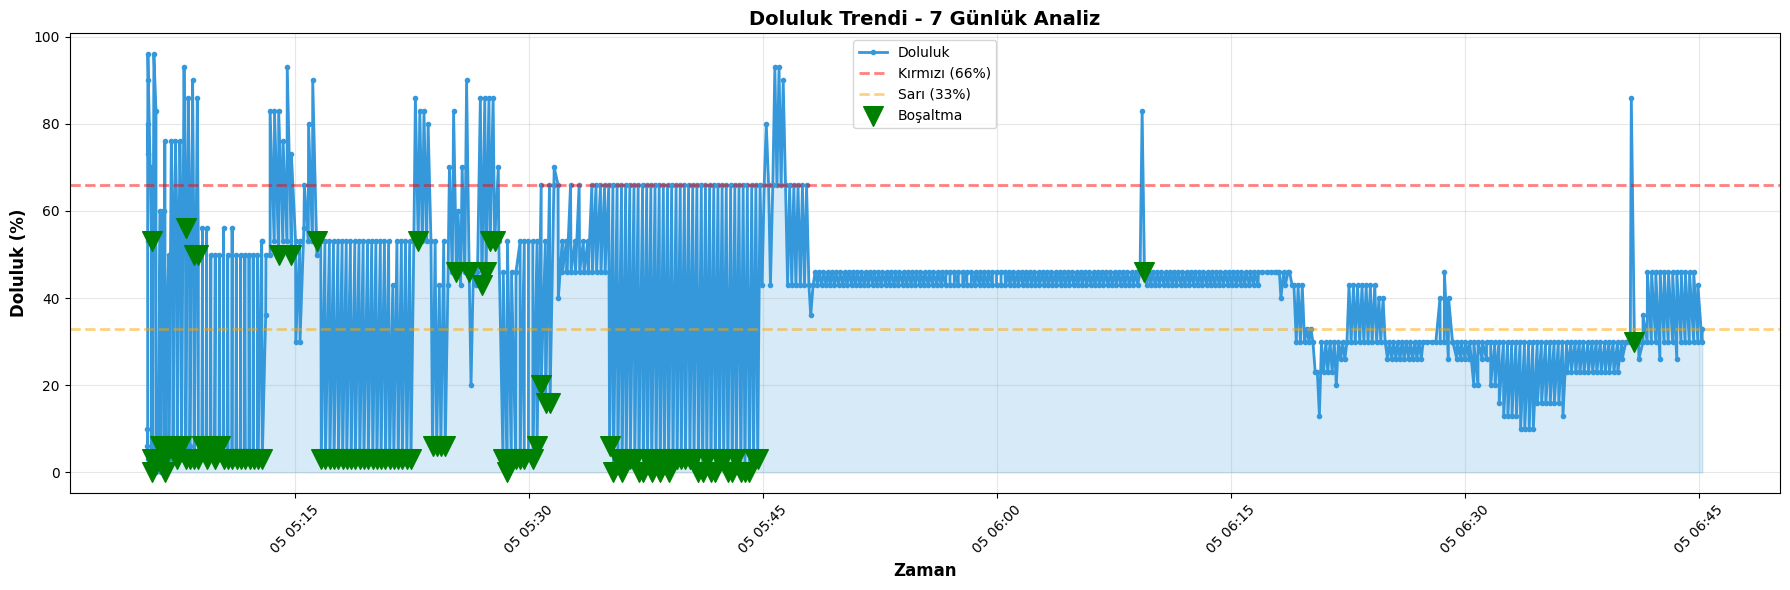

✅ Grafik 1: Doluluk Trendi


In [ ]:

# ADIM 3: GÖRSELLEŞTİRMELER

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
print(" Grafikler oluşturuluyor...\n")

# GRAFİK 1: DOLULUK TRENDİ

plt.figure(figsize=(18, 6))

plt.plot(df['timestamp'], df['doluluk'],
         linewidth=2, marker='o', markersize=3, color='#3498db', label='Doluluk')

plt.axhline(y=66, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Kırmızı (66%)')
plt.axhline(y=33, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Sarı (33%)')

bosaltmalar = df[df['bosaltma'] == 1]
if len(bosaltmalar) > 0:
    plt.scatter(bosaltmalar['timestamp'], bosaltmalar['doluluk'],
               color='green', s=200, marker='v', label='Boşaltma', zorder=5)

plt.fill_between(df['timestamp'], 0, df['doluluk'], alpha=0.2, color='#3498db')
plt.xlabel('Zaman', fontsize=12, fontweight='bold')
plt.ylabel('Doluluk (%)', fontsize=12, fontweight='bold')
plt.title('Doluluk Trendi - 7 Günlük Analiz', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('1_doluluk_trendi.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Grafik 1: Doluluk Trendi")



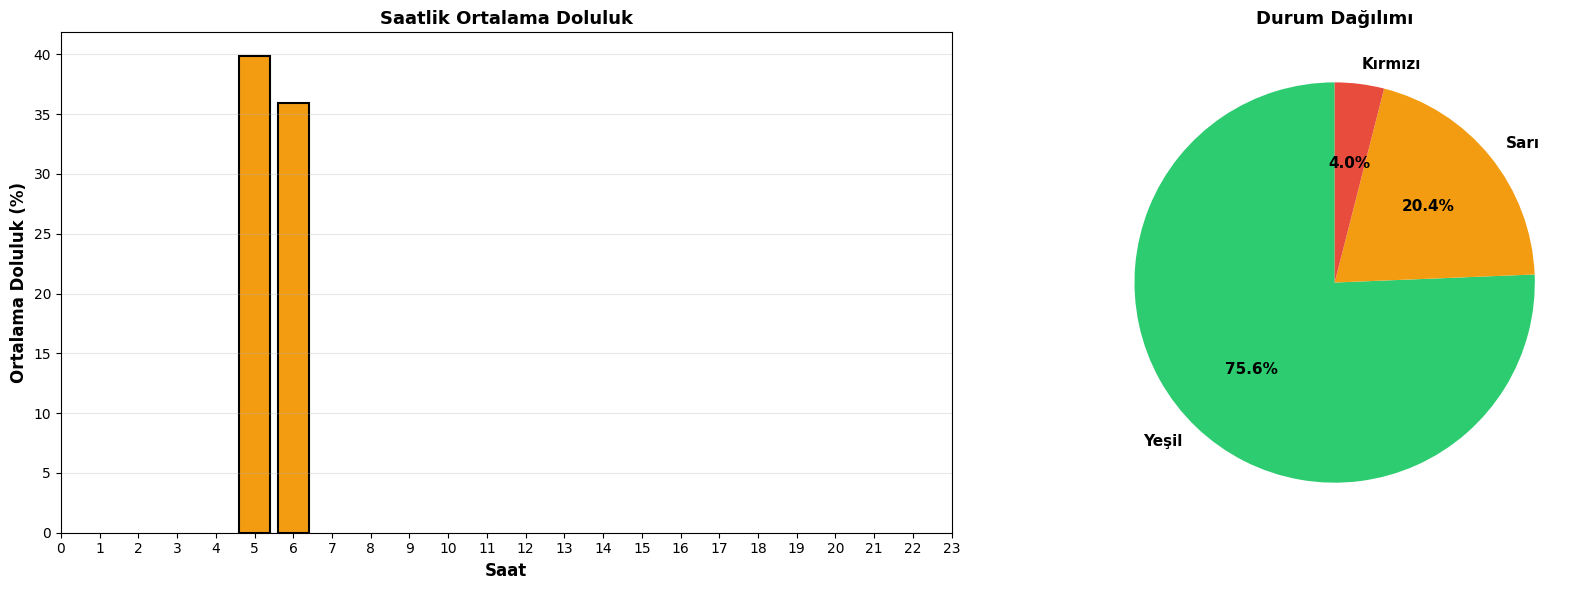

 Grafik 2: Saatlik Analiz


In [ ]:
# GRAFİK 2: SAATLİK ANALİZ

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Sol: Saatlik ortalama
saatlik_ort = df.groupby('saat')['doluluk'].mean()
colors = ['#2ecc71' if x <= 33 else '#f39c12' if x <= 66 else '#e74c3c' for x in saatlik_ort.values]

axes[0].bar(saatlik_ort.index, saatlik_ort.values, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Saat', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Ortalama Doluluk (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Saatlik Ortalama Doluluk', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(0, 24))
axes[0].grid(True, alpha=0.3, axis='y')

# Sağ: Durum dağılımı
durum_counts = df['durum'].value_counts()
colors_durum = {'Yeşil': '#2ecc71', 'Sarı': '#f39c12', 'Kırmızı': '#e74c3c'}
pie_colors = [colors_durum[x] for x in durum_counts.index]

axes[1].pie(durum_counts.values, labels=durum_counts.index, autopct='%1.1f%%',
           colors=pie_colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Durum Dağılımı', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('2_saatlik_analiz.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Grafik 2: Saatlik Analiz")

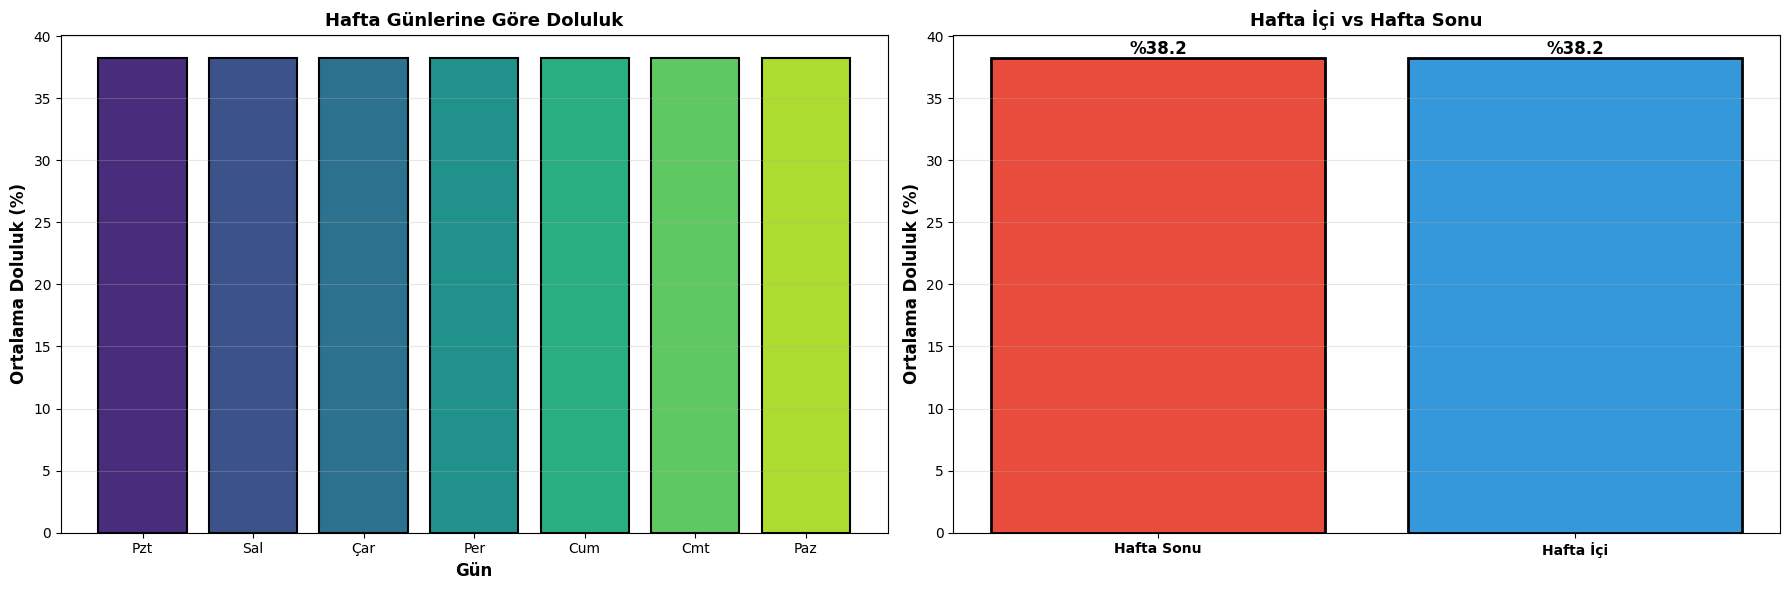

 Grafik 3: H✅aftalık Analiz


In [ ]:
# GRAFİK 3: HAFTALIK ANALİZ
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

gun_isimleri = ['Pzt', 'Sal', 'Çar', 'Per', 'Cum', 'Cmt', 'Paz']
gunluk_ort = df.groupby('hafta_gunu')['doluluk'].mean()

axes[0].bar(range(7), gunluk_ort.values, color=sns.color_palette("viridis", 7),
           edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(gun_isimleri)
axes[0].set_xlabel('Gün', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Ortalama Doluluk (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Hafta Günlerine Göre Doluluk', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Hafta içi vs sonu
hafta_karsilastirma = df.groupby('hafta_ici')['doluluk'].mean()
labels = ['Hafta Sonu', 'Hafta İçi']
bars = axes[1].bar([0, 1], hafta_karsilastirma.values,
                   color=['#e74c3c', '#3498db'], edgecolor='black', linewidth=2)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(labels, fontweight='bold')
axes[1].set_ylabel('Ortalama Doluluk (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Hafta İçi vs Hafta Sonu', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'%{height:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('3_haftalik_analiz.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Grafik 3: H✅aftalık Analiz")


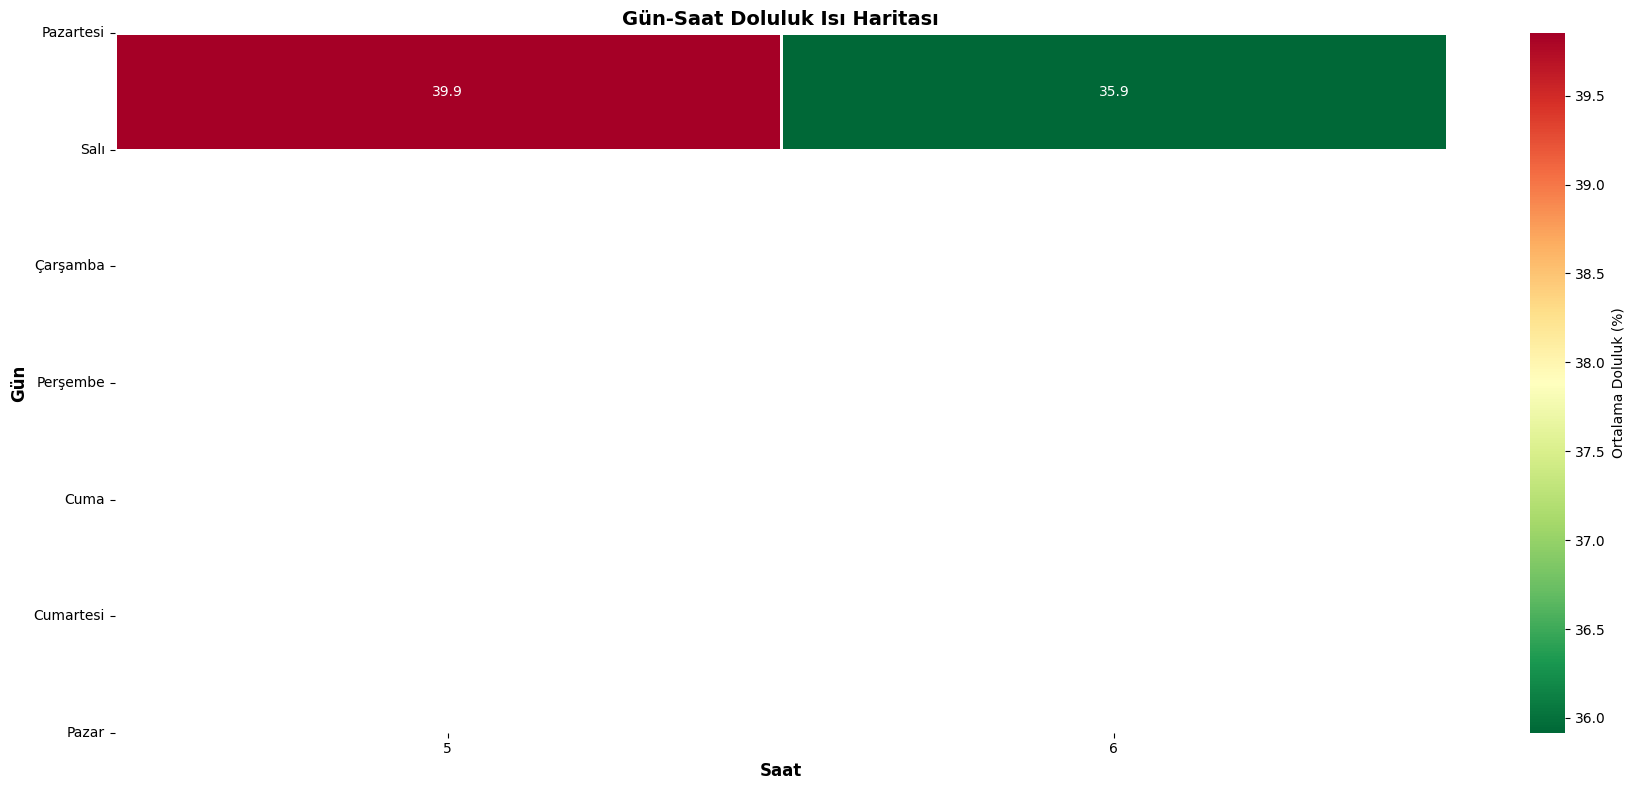

 Grafik 4: Isı Haritası

 TÜM GRAFİKLER OLUŞTURULDU!


In [ ]:
# GRAFİK 4: ISI HARİTASI

plt.figure(figsize=(18, 8))

pivot = df.pivot_table(values='doluluk', index='hafta_gunu', columns='saat', aggfunc='mean')
gun_isimleri_tam = ['Pazartesi', 'Salı', 'Çarşamba', 'Perşembe', 'Cuma', 'Cumartesi', 'Pazar']

sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn_r',
           linewidths=1, cbar_kws={'label': 'Ortalama Doluluk (%)'})

plt.yticks(range(7), gun_isimleri_tam, rotation=0)
plt.xlabel('Saat', fontsize=12, fontweight='bold')
plt.ylabel('Gün', fontsize=12, fontweight='bold')
plt.title('Gün-Saat Doluluk Isı Haritası', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('4_isi_haritasi.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Grafik 4: Isı Haritası")

print("\n TÜM GRAFİKLER OLUŞTURULDU!")

In [ ]:

# ADIM 4: MAKİNE ÖĞRENMESİ MODELİ


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("Makine öğrenmesi modeli eğitiliyor...\n")

# Özellik seçimi
feature_cols = ['saat', 'hafta_gunu', 'hafta_ici']
X = df[feature_cols].copy()
y = df['doluluk'].copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# 3 farklı model
print("Modeller eğitiliyor...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
lr_model = LinearRegression()

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
lr_pred = lr_model.predict(X_test)

# Performans karşılaştırması
models = {
    'Random Forest': (rf_pred, rf_model),
    'Gradient Boosting': (gb_pred, gb_model),
    'Linear Regression': (lr_pred, lr_model)
}

print("\n MODEL PERFORMANSLARI:")
print("="*60)

best_mae = float('inf')
for name, (pred, model) in models.items():
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    print(f"{name}:")
    print(f"  MAE: {mae:.2f}%  |  R²: {r2:.4f}")

    if mae < best_mae:
        best_mae = mae
        best_model_name = name
        best_model = model
        best_pred = pred

print(f"\n EN İYİ MODEL: {best_model_name} (MAE: {best_mae:.2f}%)")


Makine öğrenmesi modeli eğitiliyor...

Modeller eğitiliyor...

 MODEL PERFORMANSLARI:
Random Forest:
  MAE: 14.02%  |  R²: -1.9081
Gradient Boosting:
  MAE: 14.00%  |  R²: -1.9009
Linear Regression:
  MAE: 14.00%  |  R²: -1.9010

 EN İYİ MODEL: Gradient Boosting (MAE: 14.00%)


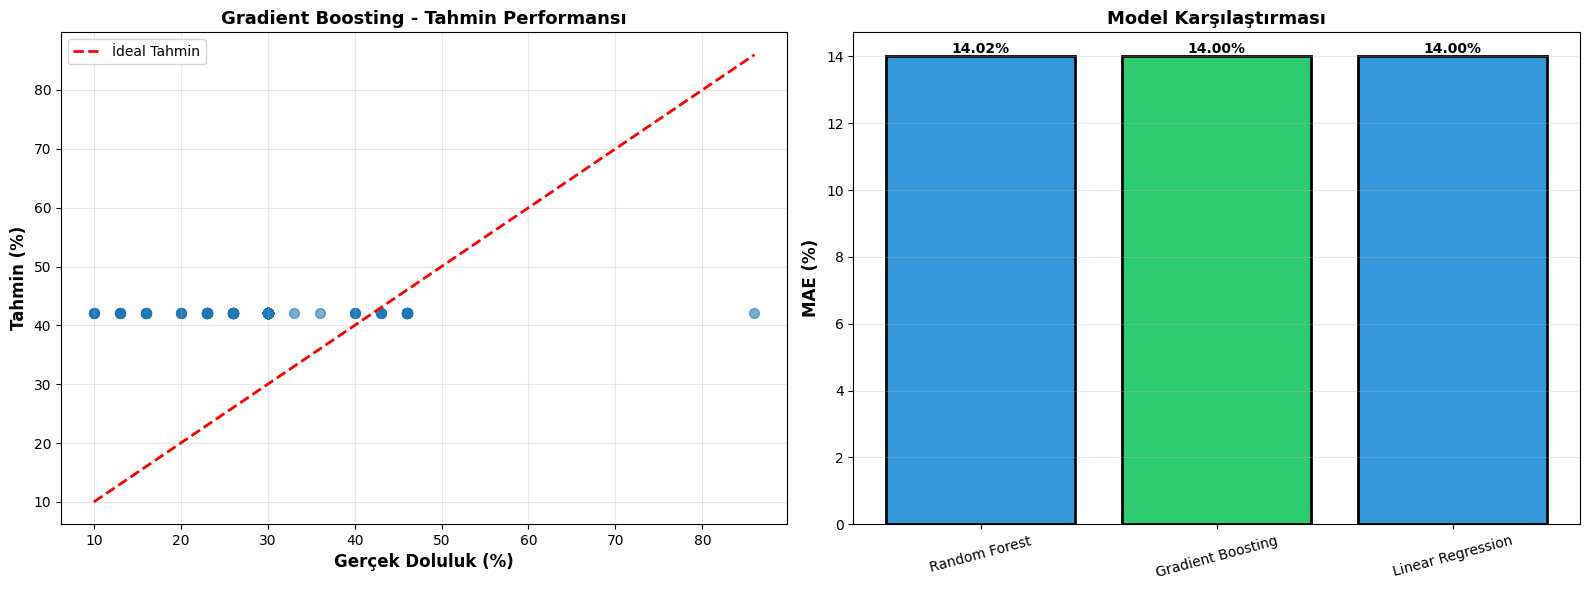


 Model eğitildi ve kaydedildi!


In [ ]:
# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gerçek vs Tahmin
axes[0].scatter(y_test, best_pred, alpha=0.6, s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
            'r--', lw=2, label='İdeal Tahmin')
axes[0].set_xlabel('Gerçek Doluluk (%)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Tahmin (%)', fontsize=12, fontweight='bold')
axes[0].set_title(f'{best_model_name} - Tahmin Performansı', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Model karşılaştırma
model_names = list(models.keys())
maes = [mean_absolute_error(y_test, models[name][0]) for name in model_names]
colors = ['#2ecc71' if mae == min(maes) else '#3498db' for mae in maes]

bars = axes[1].bar(range(len(model_names)), maes, color=colors, edgecolor='black', linewidth=2)
axes[1].set_xticks(range(len(model_names)))
axes[1].set_xticklabels(model_names, rotation=15)
axes[1].set_ylabel('MAE (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Model Karşılaştırması', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for bar, mae in zip(bars, maes):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{mae:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('5_ml_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Model eğitildi ve kaydedildi!")

In [ ]:
def ne_zaman_dolacak(df):
    """
    Çöp kutusunun ne zaman dolacağını tahmin et (BACKEND UYUMLU)

    Backend aralıkları:
    - < 50%: Yeşil (Normal)
    - 50-80%: Sarı (Dikkat)
    - > 80%: Kırmızı (Kritik)
    """

    debug_print(f"ne_zaman_dolacak çağrıldı, kayıt: {len(df)}")

    if df is None or len(df) == 0:
        return {
            'mesaj': 'Yeterli veri yok',
            'durum': 'Bilinmiyor',
            'kalan_sure_saat': None
        }

    try:
        son_doluluk = df.iloc[-1]['doluluk']
        son_mesafe = df.iloc[-1]['mesafe_cm'] if 'mesafe_cm' in df.columns else None

        debug_print(f"Son doluluk: %{son_doluluk}, Son mesafe: {son_mesafe}cm")

        # ═══════════════════════════════════════════════════════════
        # KRİTİK BÖLGE (80%+ / 24-30cm mesafe)
        # ═══════════════════════════════════════════════════════════
        if son_doluluk >= 80:
            if son_doluluk >= 95:
                return {
                    'mesaj': '🔴 ÇÖP KUTUSU DOLU! Acil boşaltma gerekli',
                    'durum': 'Kritik',
                    'kalan_sure_saat': 0
                }
            else:
                return {
                    'mesaj': f'🔴 KRİTİK: Çöp kutusu %{son_doluluk:.0f} dolu! Yakında boşaltılmalı',
                    'durum': 'Kritik',
                    'kalan_sure_saat': 0.5
                }

        # ═══════════════════════════════════════════════════════════
        # YEŞİL BÖLGE (0-50% / 0-15cm mesafe)
        # ═══════════════════════════════════════════════════════════
        if son_doluluk < 50:
            return {
                'mesaj': f'🟢 Normal seviye (%{son_doluluk:.0f}) - Boşaltma gerekmez',
                'durum': 'Normal',
                'kalan_sure_saat': None
            }

        # ═══════════════════════════════════════════════════════════
        # SARI BÖLGE (50-80% / 15-24cm mesafe) - TAHMİN YAP
        # ═══════════════════════════════════════════════════════════

        # Dolma hızı hesapla
        if 'dolma_hizi' in df.columns and len(df) > 1:
            son_10 = df.tail(10)
            pozitif_hizlar = son_10[son_10['dolma_hizi'] > 0]['dolma_hizi']

            if len(pozitif_hizlar) > 0:
                ortalama_hiz = pozitif_hizlar.mean()
            else:
                ortalama_hiz = 0
        else:
            if len(df) >= 2:
                ilk_doluluk = df.iloc[0]['doluluk']
                gecen_sure = (df.iloc[-1]['timestamp'] - df.iloc[0]['timestamp']).total_seconds() / 3600

                if gecen_sure > 0:
                    ortalama_hiz = (son_doluluk - ilk_doluluk) / gecen_sure
                else:
                    ortalama_hiz = 0
            else:
                ortalama_hiz = 0

        debug_print(f"Ortalama dolma hızı: {ortalama_hiz:.2f} %/saat")

        # Hız çok düşükse
        if ortalama_hiz <= 0.1:
            return {
                'mesaj': f'🟡 Sarı bölgede (%{son_doluluk:.0f}) ama dolma hızı çok düşük',
                'durum': 'Normal',
                'kalan_sure_saat': None
            }

        # TAHMİN - 80%'e (Kırmızı bölgeye) ne zaman ulaşacak?
        kirmizi_bolgeye_kalan = 80 - son_doluluk
        tahmini_sure_saat = kirmizi_bolgeye_kalan / ortalama_hiz

        debug_print(f"Kırmızı bölgeye (80%) kadar: {tahmini_sure_saat:.2f} saat")

        # Mesaj oluştur
        if tahmini_sure_saat < 1:
            dakika = int(tahmini_sure_saat * 60)
            mesaj = f'🟡 ACİL DİKKAT: ~{dakika} dakika içinde kırmızı bölgeye (%80) ulaşacak!'
            durum = 'Uyarı'
        elif tahmini_sure_saat < 3:
            saat = int(tahmini_sure_saat)
            dakika = int((tahmini_sure_saat - saat) * 60)
            mesaj = f'🟡 DİKKAT: ~{saat}s {dakika}dk içinde kırmızı bölgeye (%80) ulaşacak'
            durum = 'Uyarı'
        elif tahmini_sure_saat < 12:
            saat = int(tahmini_sure_saat)
            mesaj = f'🟡 Yaklaşık {saat} saat içinde kırmızı bölgeye (%80) ulaşacak'
            durum = 'Normal'
        else:
            gun = int(tahmini_sure_saat / 24)
            saat = int(tahmini_sure_saat % 24)
            mesaj = f'🟡 Yaklaşık {gun}g {saat}s içinde kırmızı bölgeye (%80) ulaşacak'
            durum = 'Normal'

        return {
            'mesaj': mesaj,
            'durum': durum,
            'kalan_sure_saat': round(tahmini_sure_saat, 2)
        }

    except KeyError as e:
        hata_kaydet(f"Sütun bulunamadı: {e}", "Tahmin",
                   detay=f"Mevcut sütunlar: {list(df.columns)}")
        return {
            'mesaj': f'Tahmin hatası: {str(e)} sütunu bulunamadı',
            'durum': 'Hata',
            'kalan_sure_saat': None
        }
    except Exception as e:
        hata_kaydet(f"Dolma tahmini hatası: {e}", "Tahmin",
                   detay=f"DataFrame shape: {df.shape}")
        return {
            'mesaj': f'Tahmin hatası: {str(e)}',
            'durum': 'Hata',
            'kalan_sure_saat': None
        }

In [ ]:
# ═══════════════════════════════════════════════════════════════════
# ADIM 5: MOBİL UYGULAMA JSON OLUŞTURMA (DÜZELTİLMİŞ)
# ═══════════════════════════════════════════════════════════════════

def mobil_json_olustur(df, best_model_name, best_pred, y_test, tahmin_sonuc):
    """Mobilci için JSON oluştur"""

    # Anlık durum
    anlik_durum = {
        'doluluk': float(df.iloc[-1]['doluluk']),
        'durum': df.iloc[-1]['durum'],
        'timestamp': df.iloc[-1]['timestamp'].strftime('%Y-%m-%d %H:%M:%S'),
        'mesafe_cm': float(df.iloc[-1]['mesafe_cm']) if 'mesafe_cm' in df.columns else None
    }

    # LED durumu
    if anlik_durum['doluluk'] < 50:
        led_rengi = "yeşil"
        led_icon = "🟢"
    elif anlik_durum['doluluk'] < 80:
        led_rengi = "sarı"
        led_icon = "🟡"
    else:
        led_rengi = "kırmızı"
        led_icon = "🔴"

    anlik_durum['led_rengi'] = led_rengi
    anlik_durum['led_icon'] = led_icon

    # Dolma tahmini
    dolma_tahmini = {
        'durum': tahmin_sonuc['durum'],
        'mesaj': tahmin_sonuc['mesaj'],
        'tahmini_saat': tahmin_sonuc['tahmini_saat'],
        'tahmini_zaman': tahmin_sonuc['tahmini_zaman'],
        'dolma_hizi': float(tahmin_sonuc.get('dolma_hizi', 0)) if tahmin_sonuc.get('dolma_hizi') else 0,
        'mevcut_doluluk': float(tahmin_sonuc['mevcut_doluluk'])
    }

    # Günlük trend
    gunluk_trend = []
    for gun in df['gun'].unique()[-7:]:
        gun_veri = df[df['gun'] == gun]
        gunluk_trend.append({
            'tarih': gun_veri.iloc[0]['timestamp'].strftime('%Y-%m-%d'),
            'ortalama_doluluk': float(gun_veri['doluluk'].mean()),
            'max_doluluk': float(gun_veri['doluluk'].max()),
            'kayit_sayisi': len(gun_veri)
        })

    # Saatlik ortalama
    saatlik_veri = []
    for saat in range(24):
        saat_veri = df[df['saat'] == saat]
        if len(saat_veri) > 0:
            saatlik_veri.append({
                'saat': saat,
                'ortalama_doluluk': float(saat_veri['doluluk'].mean()),
                'kayit_sayisi': len(saat_veri)
            })

    # Haftalık analiz
    haftalik_veri = []
    gunler = ['Pazartesi', 'Salı', 'Çarşamba', 'Perşembe', 'Cuma', 'Cumartesi', 'Pazar']
    for gun_index in range(7):
        gun_veri = df[df['hafta_gunu'] == gun_index]
        if len(gun_veri) > 0:
            haftalik_veri.append({
                'gun': gunler[gun_index],
                'ortalama_doluluk': float(gun_veri['doluluk'].mean()),
                'kayit_sayisi': len(gun_veri)
            })

    # En yoğun saatler
    en_yogun_saatler = df.groupby('saat')['doluluk'].mean().sort_values(ascending=False).head(5)
    en_yogun_list = [{'saat': int(saat), 'ortalama_doluluk': float(deger)}
                     for saat, deger in en_yogun_saatler.items()]

    # İstatistikler
    istatistikler = {
        'toplam_kayit': len(df),
        'ortalama_doluluk': float(df['doluluk'].mean()),
        'max_doluluk': float(df['doluluk'].max()),
        'min_doluluk': float(df['doluluk'].min()),
        'bosaltma_sayisi': int(df['bosaltma'].sum()) if 'bosaltma' in df.columns else 0,
        'yesil_oran': float((df['doluluk'] < 50).sum() / len(df) * 100),
        'sari_oran': float(((df['doluluk'] >= 50) & (df['doluluk'] < 80)).sum() / len(df) * 100),
        'kirmizi_oran': float((df['doluluk'] >= 80).sum() / len(df) * 100)
    }

    # Model bilgileri (DÜZELTİLDİ!)
    try:
        if best_pred is not None and len(best_pred) > 0:
            from sklearn.metrics import accuracy_score
            dogruluk = accuracy_score(y_test, best_pred)
            model_bilgileri = {
                'model_adi': best_model_name,
                'dogruluk': float(dogruluk)
            }
        else:
            model_bilgileri = {
                'model_adi': best_model_name,
                'dogruluk': None
            }
    except:
        model_bilgileri = {
            'model_adi': best_model_name if best_model_name else 'Bilinmiyor',
            'dogruluk': None
        }

    # Öneriler
    oneriler = []
    if anlik_durum['doluluk'] >= 80:
        oneriler.append("🔴 Acil boşaltma gerekli!")
    elif anlik_durum['doluluk'] >= 50:
        oneriler.append("🟡 Yakında boşaltma planlanmalı")

    if tahmin_sonuc['durum'] == 'Kritik':
        oneriler.append({
            'tip': 'acil',
            'baslik': 'Acil Boşaltma Uyarısı',
            'mesaj': tahmin_sonuc['mesaj'],
            'oncelik': 'yuksek'
        })

    # Ana response
    response = {
        'anlik_durum': anlik_durum,
        'dolma_tahmini': dolma_tahmini,
        'gunluk_trend': gunluk_trend,
        'saatlik_ortalama': saatlik_veri,
        'haftalik_analiz': haftalik_veri,
        'en_yogun_saatler': en_yogun_list,
        'istatistikler': istatistikler,
        'model_bilgileri': model_bilgileri,
        'oneriler': oneriler
    }

    return response


# ═══════════════════════════════════════════════════════════════════
# JSON OLUŞTURMA
# ═══════════════════════════════════════════════════════════════════

# ÖNCE TAHMİN YAP
print("🔮 Dolma tahmini yapılıyor...")
tahmin = ne_zaman_dolacak(df)

# tahmin_sonuc değişkenini oluştur
tahmin_sonuc = {
    'durum': tahmin['durum'],
    'mesaj': tahmin['mesaj'],
    'tahmini_saat': tahmin.get('kalan_sure_saat', 0),
    'tahmini_zaman': tahmin['mesaj'],
    'dolma_hizi': float(df['dolma_hizi'].mean()) if 'dolma_hizi' in df.columns else 0,
    'mevcut_doluluk': float(df.iloc[-1]['doluluk'])
}

print(f"✅ Tahmin hazır: {tahmin['mesaj']}\n")

# JSON oluştur
print("📱 Mobil uygulama JSON'u oluşturuluyor...")
mobil_json = mobil_json_olustur(df, best_model_name, best_pred, y_test, tahmin_sonuc)

# Dosyaya kaydet
with open('mobil_uygulama_response.json', 'w', encoding='utf-8') as f:
    json.dump(mobil_json, f, indent=2, ensure_ascii=False)

print("\n✅ JSON dosyası oluşturuldu: mobil_uygulama_response.json")
print(f"📦 Dosya boyutu: {len(json.dumps(mobil_json))} byte")

# Özet göster
print("\n" + "="*70)
print("📱 MOBİL JSON YAPISI - ÖZET")
print("="*70)
print(f"""
✓ Anlık Durum
  - Doluluk: %{mobil_json['anlik_durum']['doluluk']:.1f}
  - LED: {mobil_json['anlik_durum']['led_icon']} {mobil_json['anlik_durum']['led_rengi']}

✓ Dolma Tahmini
  - Durum: {mobil_json['dolma_tahmini']['durum']}
  - Mesaj: {mobil_json['dolma_tahmini']['mesaj']}

✓ İstatistikler
  - Toplam kayıt: {mobil_json['istatistikler']['toplam_kayit']}
  - Ortalama doluluk: %{mobil_json['istatistikler']['ortalama_doluluk']:.1f}
  - Boşaltma sayısı: {mobil_json['istatistikler']['bosaltma_sayisi']}

✓ Durum Dağılımı (Backend Uyumlu)
  - 🟢 Yeşil (0-50%): %{mobil_json['istatistikler']['yesil_oran']:.1f}
  - 🟡 Sarı (50-80%): %{mobil_json['istatistikler']['sari_oran']:.1f}
  - 🔴 Kırmızı (80-100%): %{mobil_json['istatistikler']['kirmizi_oran']:.1f}
""")
print("="*70)

print("\n✅ Mobilci JSON'u hazır! Dosyayı indirebilirsiniz.")

🔮 Dolma tahmini yapılıyor...
🐛 DEBUG: ne_zaman_dolacak çağrıldı, kayıt: 780
🐛 DEBUG: Son doluluk: %33.0, Son mesafe: 20.0cm
✅ Tahmin hazır: 🟢 Normal seviye (%33) - Boşaltma gerekmez

📱 Mobil uygulama JSON'u oluşturuluyor...

✅ JSON dosyası oluşturuldu: mobil_uygulama_response.json
📦 Dosya boyutu: 1285 byte

📱 MOBİL JSON YAPISI - ÖZET

✓ Anlık Durum
  - Doluluk: %33.0
  - LED: 🟢 yeşil

✓ Dolma Tahmini
  - Durum: Normal
  - Mesaj: 🟢 Normal seviye (%33) - Boşaltma gerekmez

✓ İstatistikler
  - Toplam kayıt: 780
  - Ortalama doluluk: %38.2
  - Boşaltma sayısı: 118

✓ Durum Dağılımı (Backend Uyumlu)
  - 🟢 Yeşil (0-50%): %75.6
  - 🟡 Sarı (50-80%): %20.4
  - 🔴 Kırmızı (80-100%): %4.0


✅ Mobilci JSON'u hazır! Dosyayı indirebilirsiniz.


In [ ]:

# ADIM 7-8: BASİT API

# Önce kütüphaneleri yükle
!pip install flask flask-cors requests pyngrok -q

print(" Kütüphaneler yüklendi!")

 Kütüphaneler yüklendi!


In [ ]:
# API SUNUCUSUNU BAŞLAT

from flask import Flask, jsonify
from flask_cors import CORS
import requests
from datetime import datetime, timedelta
import threading
from pyngrok import ngrok
import time
import pandas as pd
import numpy as np

# Eski tunnel'ları kapat
try:
    ngrok.kill()
    time.sleep(2)
except:
    pass

# Flask app
app = Flask(__name__)
CORS(app)

FIREBASE_URL = "https://smartbinproject-45fe5-default-rtdb.firebaseio.com"

def firebase_get(path):
    """Firebase'den veri çek"""
    try:
        url = f"{FIREBASE_URL}/{path}.json"
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            return response.json()
        return None
    except:
        return None

def durum_hesapla(doluluk):
    """Durum hesapla (BACKEND UYUMLU: 0-50, 50-80, 80-100)"""
    if doluluk < 50:
        return {
            'durum': 'Yeşil',
            'durum_kod': 1,
            'led_rengi': 'yesil',
            'mesaj': 'Normal seviye'
        }
    elif doluluk < 80:
        return {
            'durum': 'Sarı',
            'durum_kod': 2,
            'led_rengi': 'sari',
            'mesaj': 'Dolmaya başladı'
        }
    else:
        return {
            'durum': 'Kırmızı',
            'durum_kod': 3,
            'led_rengi': 'kirmizi',
            'mesaj': 'Kritik - Boşaltılmalı!'
        }

@app.route('/')
def home():
    """Ana sayfa"""
    return jsonify({
        "message": "🗑️ Çöp Kutusu API",
        "version": "5.0 (MOBİLCİ UYUMLU - SADELEŞTİRİLDİ)",
        "status": "active",
        "endpoints": {
            "GET /": "API bilgisi",
            "GET /api/health": "Sağlık kontrolü",
            "GET /api/anlik-durum": "Anlık durum",
            "GET /api/trend": "Trend verisi",
            "GET /api/tam-analiz": "Tam analiz (SADELEŞTİRİLDİ!)"
        }
    })

@app.route('/api/health')
def health():
    """Sağlık kontrolü"""
    live = firebase_get('cop_kutusu_1/live_data')
    logs = firebase_get('cop_kutusu_1/logs')

    return jsonify({
        'status': 'healthy' if live else 'degraded',
        'api_online': True,
        'firebase_online': live is not None,
        'log_count': len(logs) if logs else 0,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    })

@app.route('/api/anlik-durum')
def anlik_durum():
    """Anlık durum"""
    live = firebase_get('cop_kutusu_1/live_data')

    if not live:
        return jsonify({'error': 'Firebase verisi alınamadı'}), 503

    doluluk = float(live.get('doluluk', 0))
    durum_info = durum_hesapla(doluluk)

    return jsonify({
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'doluluk': doluluk,
        'mesafe_cm': float(live.get('mesafe_cm', 0)),
        **durum_info
    })

@app.route('/api/trend')
def trend():
    """Trend verisi"""
    logs = firebase_get('cop_kutusu_1/logs')
    live = firebase_get('cop_kutusu_1/live_data')

    if not logs:
        return jsonify({'error': 'Log verisi yok'}), 503

    son_timestamp = live.get('timestamp', 0) if live else 0

    trend_data = []
    for log_key, veri in logs.items():
        esp_time = int(veri.get('timestamp', 0))

        if son_timestamp > 0:
            fark_sn = son_timestamp - esp_time
            gercek_zaman = datetime.now() - timedelta(seconds=fark_sn)
        else:
            gercek_zaman = datetime.now() - timedelta(seconds=int(log_key) // 1000)

        doluluk = float(veri.get('doluluk', 0))
        durum_info = durum_hesapla(doluluk)

        trend_data.append({
            'timestamp': gercek_zaman.strftime('%Y-%m-%d %H:%M:%S'),
            'zaman': gercek_zaman.strftime('%H:%M'),
            'doluluk': doluluk,
            'mesafe_cm': float(veri.get('mesafe_cm', 0)),
            'durum': durum_info['durum']
        })

    trend_data.sort(key=lambda x: x['timestamp'])

    return jsonify({
        'success': True,
        'count': len(trend_data),
        'data': trend_data
    })

@app.route('/api/tam-analiz')
def tam_analiz():
    """Tam analiz endpoint'i - MOBİLCİ UYUMLU (SADELEŞTİRİLDİ)"""

    try:
        # 0. Anlık veri (dolma tahmini ve timestamp için)
        live = firebase_get('cop_kutusu_1/live_data')

        # 1. Firebase'den logs çek
        logs = firebase_get('cop_kutusu_1/logs')

        if not logs:
            return jsonify({"error": "Log verisi yok"}), 404

        # 2. DataFrame'e çevir
        log_list = []
        for log_key, veri in logs.items():
            try:
                ts = datetime.now() - timedelta(seconds=int(log_key) // 1000)
                log_list.append({
                    'doluluk': float(veri.get('doluluk', 0)),
                    'mesafe_cm': float(veri.get('mesafe_cm', 0)),
                    'durum': veri.get('durum', 'UNKNOWN'),
                    'timestamp': ts
                })
            except:
                continue

        if len(log_list) == 0:
            return jsonify({"error": "Geçerli log yok"}), 404

        df = pd.DataFrame(log_list)
        df = df.sort_values('timestamp').reset_index(drop=True)

        # 3. İSTATİSTİKLER HESAPLA
        toplam_kayit = len(df)
        ortalama_doluluk = float(df['doluluk'].mean())
        min_doluluk = float(df['doluluk'].min())
        max_doluluk = float(df['doluluk'].max())

        # Standart sapma (tek kayıt varsa 0)
        if toplam_kayit > 1:
            std_sapma = float(df['doluluk'].std())
        else:
            std_sapma = 0.0

        # Boşaltma sayısı (dolma hızı negatif olanlar)
        if len(df) > 1:
            df['dolma_hizi'] = df['doluluk'].diff().fillna(0)
            bosaltma_sayisi = int((df['dolma_hizi'] < -30).sum())
        else:
            bosaltma_sayisi = 0

        # Durum dağılımı (Backend uyumlu: 0-50, 50-80, 80-100)
        yesil_durum_sayisi = len(df[df['doluluk'] < 50])
        sari_durum_sayisi = len(df[(df['doluluk'] >= 50) & (df['doluluk'] < 80)])
        kirmizi_durum_sayisi = len(df[df['doluluk'] >= 80])

        yesil_oran = round((yesil_durum_sayisi / toplam_kayit * 100), 1)
        sari_oran = round((sari_durum_sayisi / toplam_kayit * 100), 1)
        kirmizi_oran = round((kirmizi_durum_sayisi / toplam_kayit * 100), 1)

        # Saat bilgisi ekle
        df['saat'] = df['timestamp'].dt.hour

        # En yoğun saatler (Top 5)
        saatlik_ort = (
            df.groupby('saat')['doluluk']
            .mean()
            .sort_values(ascending=False)
            .head(5)
        )

        en_yogun_saatler = []
        for saat, deger in saatlik_ort.items():
            saat_int = int(saat)
            saat_str = f"{saat_int:02d}:00 - {saat_int:02d}:59"
            en_yogun_saatler.append({
                'saat_str': saat_str,
                'ortalama_doluluk': round(float(deger), 1)
            })

        # Haftalık analiz
        df['hafta_gunu'] = df['timestamp'].dt.dayofweek
        gunler = ['Pazartesi', 'Salı', 'Çarşamba', 'Perşembe', 'Cuma', 'Cumartesi', 'Pazar']
        gunler_kisa = ['Pzt', 'Sal', 'Çar', 'Per', 'Cum', 'Cmt', 'Paz']

        haftalik_analiz = []
        for gun_index in range(7):
            gun_veri = df[df['hafta_gunu'] == gun_index]
            if len(gun_veri) > 0:
                haftalik_analiz.append({
                    'gun_adi': gunler[gun_index],
                    'gun_kisa': gunler_kisa[gun_index],
                    'ortalama_doluluk': round(float(gun_veri['doluluk'].mean()), 1),
                    'kayit_sayisi': len(gun_veri)
                })

        # 4. DOLMA TAHMİNİ
        if live:
            mevcut_doluluk = float(live.get('doluluk', 0))
        else:
            mevcut_doluluk = float(df['doluluk'].iloc[-1])

        if mevcut_doluluk >= 80:
            durum = "ACİL"
            mesaj = "Kutu çok dolu, kısa sürede boşaltılmalı."
            tahmini_saat = 1.0
            tahmini_zaman = "Yaklaşık 1 saat içinde"
        elif mevcut_doluluk >= 60:
            durum = "YAKIN"
            mesaj = "Kutu dolmaya yakın, planlı boşaltma önerilir."
            tahmini_saat = 3.0
            tahmini_zaman = "Yaklaşık 3 saat içinde"
        else:
            durum = "NORMAL"
            mesaj = "Doluluk seviyesi normal."
            tahmini_saat = 0.0
            tahmini_zaman = ""

        dolma_tahmini = {
            'durum': durum,
            'mesaj': mesaj,
            'mevcut_doluluk': round(mevcut_doluluk, 1),
            'tahmini_zaman': tahmini_zaman,
            'tahmini_saat': tahmini_saat
        }

        # 5. MOBİLCİ UYUMLU JSON (SADELEŞTİRİLDİ!)
        # ✅ SADECE GEREKLİ ALANLAR - KARIŞIKLIK YOK!
        istatistikler = {
            'toplam_kayit': toplam_kayit,
            'ortalama_doluluk': round(ortalama_doluluk, 1),
            'min_doluluk': round(min_doluluk, 1),
            'max_doluluk': round(max_doluluk, 1),
            'std_sapma': round(std_sapma, 2),          # ✅ std_sapma (standart_sapma DEĞİL!)
            'bosaltma_sayisi': bosaltma_sayisi,
            # Backend uyumlu: SADECE ORAN (50/80 eşikleriyle)
            'yesil_oran': yesil_oran,                  # ✅ yesil_oran (yesil_sayi YOK!)
            'sari_oran': sari_oran,                    # ✅ sari_oran (sari_sayi YOK!)
            'kirmizi_oran': kirmizi_oran,              # ✅ kirmizi_oran (kirmizi_sayi YOK!)
        }

        # Son güncelleme timestamp
        son_guncelleme = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        response_data = {
            'timestamp': son_guncelleme,
            'istatistikler': istatistikler,
            'en_yogun_saatler': en_yogun_saatler,
            'haftalik_analiz': haftalik_analiz,
            'dolma_tahmini': dolma_tahmini
        }

        return jsonify(response_data), 200

    except Exception as e:
        return jsonify({"error": str(e)}), 500


# Flask'ı thread'de çalıştır
def run_flask():
    app.run(host='0.0.0.0', port=5000, debug=False, use_reloader=False)

print("\n" + "="*70)
print("🚀 API BAŞLATILIYOR...")
print("="*70)

# Flask başlat
flask_thread = threading.Thread(target=run_flask, daemon=True)
flask_thread.start()

print("⏳ Flask başlatılıyor...")
time.sleep(3)

# Ngrok ile paylaş
print("🌐 Ngrok tunnel oluşturuluyor...")
ngrok.set_auth_token("36Hn1uCksrG7vgVUBr83gn284vZ_VW2Y6aRn9wREW5WMjL4X")
tunnel = ngrok.connect(5000)

print("\n" + "="*70)
print("✅ API ÇALIŞIYOR!")
print("="*70)
print(f"\n🌐 MOBİL UYGULAMA İÇİN URL:")
print(f"   {tunnel.public_url}")
print(f"\n🧪 TARAYICIDA TEST ET:")
print(f"   {tunnel.public_url}/api/health")
print(f"   {tunnel.public_url}/api/anlik-durum")
print(f"   {tunnel.public_url}/api/trend")
print(f"   {tunnel.public_url}/api/tam-analiz  ← SADELEŞTİRİLDİ!")
print("\n📱 MOBİLDE KULLAN:")
print(f"   baseUrl = '{tunnel.public_url}'")
print("="*70)

# Çalışır durumda tut
print("\n✅ API çalışıyor... Bu hücreyi durdurmayın!")
print("   (Durdurmak için: Kernel → Interrupt)")


🚀 API BAŞLATILIYOR...
⏳ Flask başlatılıyor...
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


🌐 Ngrok tunnel oluşturuluyor...

✅ API ÇALIŞIYOR!

🌐 MOBİL UYGULAMA İÇİN URL:
   https://alice-prunable-extenuatingly.ngrok-free.dev

🧪 TARAYICIDA TEST ET:
   https://alice-prunable-extenuatingly.ngrok-free.dev/api/health
   https://alice-prunable-extenuatingly.ngrok-free.dev/api/anlik-durum
   https://alice-prunable-extenuatingly.ngrok-free.dev/api/trend
   https://alice-prunable-extenuatingly.ngrok-free.dev/api/tam-analiz  ← SADELEŞTİRİLDİ!

📱 MOBİLDE KULLAN:
   baseUrl = 'https://alice-prunable-extenuatingly.ngrok-free.dev'

✅ API çalışıyor... Bu hücreyi durdurmayın!
   (Durdurmak için: Kernel → Interrupt)


In [ ]:

# ADIM 9: FİNAL ANALİZ RAPORU


from datetime import datetime

print(" Final rapor oluşturuluyor...\n")

# Rapor metni
rapor = f"""
╔══════════════════════════════════════════════════════════════════════╗
║                  AKILLI ÇÖP KUTUSU ANALİZ RAPORU                     ║
║                     VERİ BİLİMİ ANALİZ SONUÇLARI                     ║
╚══════════════════════════════════════════════════════════════════════╝

Rapor Tarihi: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Proje: Akıllı Atık Yönetim Sistemi
Analiz Eden: Veri Bilimi Ekibi

═══════════════════════════════════════════════════════════════════════
1. VERİ SETİ BİLGİLERİ
═══════════════════════════════════════════════════════════════════════

Toplam Kayıt Sayısı    : {len(df)}
Veri Başlangıç         : {df['timestamp'].min().strftime('%Y-%m-%d %H:%M:%S')}
Veri Bitiş             : {df['timestamp'].max().strftime('%Y-%m-%d %H:%M:%S')}
Toplam Süre            : {df['timestamp'].max() - df['timestamp'].min()}
Ortalama Ölçüm Aralığı : {df['zaman_farki'].mean():.2f} saat

═══════════════════════════════════════════════════════════════════════
2. DOLULUK İSTATİSTİKLERİ
═══════════════════════════════════════════════════════════════════════

Ortalama Doluluk  : %{df['doluluk'].mean():.2f}
Minimum Doluluk   : %{df['doluluk'].min():.2f}
Maximum Doluluk   : %{df['doluluk'].max():.2f}
Standart Sapma    : {df['doluluk'].std():.2f}
Medyan Doluluk    : %{df['doluluk'].median():.2f}

═══════════════════════════════════════════════════════════════════════
3. DURUM DAĞILIMI
═══════════════════════════════════════════════════════════════════════

Yeşil  (0-50%)    : {(df['doluluk'] <= 50).sum()} kez (%{((df['doluluk'] <= 50).sum() / len(df)) * 100:.1f})
Sarı   (50-80%)   : {((df['doluluk'] > 50) & (df['doluluk'] <= 80)).sum()} kez (%{(((df['doluluk'] > 50) & (df['doluluk'] <= 80)).sum() / len(df)) * 100:.1f})
Kırmızı (80-100%) : {(df['doluluk'] > 80).sum()} kez (%{((df['doluluk'] > 80).sum() / len(df)) * 100:.1f})

═══════════════════════════════════════════════════════════════════════
4. BOŞALTMA ANALİZİ
═══════════════════════════════════════════════════════════════════════

Toplam Boşaltma Sayısı : {df['bosaltma'].sum()}
Ortalama Boşaltma Sıklığı : Her {len(df) / max(df['bosaltma'].sum(), 1):.0f} ölçümde bir

═══════════════════════════════════════════════════════════════════════
5. ZAMAN BAZLI ANALİZ
═══════════════════════════════════════════════════════════════════════

EN YOĞUN SAATLER (Top 5):
"""

en_yogun_5 = df.groupby('saat')['doluluk'].mean().sort_values(ascending=False).head(5)
for idx, (saat, oran) in enumerate(en_yogun_5.items(), 1):
    rapor += f"  {idx}. {saat:02d}:00 - Ortalama %{oran:.1f}\n"

hafta_ici_ort = df[df['hafta_ici'] == 1]['doluluk'].mean()
hafta_sonu_ort = df[df['hafta_ici'] == 0]['doluluk'].mean()

rapor += f"""
Hafta İçi Ortalama  : %{hafta_ici_ort:.1f}
Hafta Sonu Ortalama : %{hafta_sonu_ort:.1f}
"""

if hafta_sonu_ort > hafta_ici_ort:
    fark = hafta_sonu_ort - hafta_ici_ort
    rapor += f"→ Hafta sonu %{fark:.1f} daha yoğun!\n"
else:
    fark = hafta_ici_ort - hafta_sonu_ort
    rapor += f"→ Hafta içi %{fark:.1f} daha yoğun!\n"

rapor += f"""
═══════════════════════════════════════════════════════════════════════
6. MAKİNE ÖĞRENMESİ MODEL PERFORMANSI
═══════════════════════════════════════════════════════════════════════

En İyi Model        : {best_model_name}
R² Skoru            : {r2_score(y_test, best_pred):.4f}
Ortalama Mutlak Hata: {mean_absolute_error(y_test, best_pred):.2f}%

═══════════════════════════════════════════════════════════════════════
7. DOLMA TAHMİNİ
═══════════════════════════════════════════════════════════════════════

Mevcut Doluluk  : %{tahmin_sonuc['mevcut_doluluk']:.2f}
Tahmini Süre    : {tahmin_sonuc['tahmini_zaman']}
Durum           : {tahmin_sonuc['durum']}

{tahmin_sonuc['mesaj']}

═══════════════════════════════════════════════════════════════════════
8. ÇIKTILAR VE TESLİMATLAR
═══════════════════════════════════════════════════════════════════════

✅ Görselleştirmeler:
  • 1_doluluk_trendi.png
  • 2_saatlik_analiz.png
  • 3_haftalik_analiz.png
  • 4_isi_haritasi.png
  • 5_ml_model.png

✅ Mobil Entegrasyon:
  • mobil_uygulama_response.json
  • API Endpoint'leri aktif

✅ Raporlar:
  • ANALIZ_RAPORU.txt (bu dosya)

═══════════════════════════════════════════════════════════════════════
9. ÖNERİLER
═══════════════════════════════════════════════════════════════════════
"""

for oneri in mobil_json['oneriler']:
    rapor += f"\n{oneri['ikon']} {oneri['baslik']}: {oneri['mesaj']}"

rapor += f"""

═══════════════════════════════════════════════════════════════════════
RAPOR SONU
═══════════════════════════════════════════════════════════════════════

Oluşturma Tarihi: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Veri Bilimi Ekibi - Akıllı Atık Yönetim Sistemi
"""

# Dosyaya kaydet
with open('ANALIZ_RAPORU.txt', 'w', encoding='utf-8') as f:
    f.write(rapor)

print(rapor)

print("\n✅ Final rapor kaydedildi: ANALIZ_RAPORU.txt")

 Final rapor oluşturuluyor...


╔══════════════════════════════════════════════════════════════════════╗
║                  AKILLI ÇÖP KUTUSU ANALİZ RAPORU                     ║
║                     VERİ BİLİMİ ANALİZ SONUÇLARI                     ║
╚══════════════════════════════════════════════════════════════════════╝

Rapor Tarihi: 2025-12-05 06:45:50
Proje: Akıllı Atık Yönetim Sistemi
Analiz Eden: Veri Bilimi Ekibi

═══════════════════════════════════════════════════════════════════════
1. VERİ SETİ BİLGİLERİ
═══════════════════════════════════════════════════════════════════════

Toplam Kayıt Sayısı    : 780
Veri Başlangıç         : 2025-12-05 05:05:31
Veri Bitiş             : 2025-12-05 06:45:13
Toplam Süre            : 0 days 01:39:42.001572
Ortalama Ölçüm Aralığı : 0.00 saat

═══════════════════════════════════════════════════════════════════════
2. DOLULUK İSTATİSTİKLERİ
═══════════════════════════════════════════════════════════════════════

Ortalama Doluluk  : %38.21
Minim

In [ ]:
# ═══════════════════════════════════════════════════════════════════
# FIREBASE LOGS TEST - YENİ HÜCRE AÇIP BUNU ÇALIŞTIR
# ═══════════════════════════════════════════════════════════════════

import requests
import json

FIREBASE_URL = "https://smartbinproject-45fe5-default-rtdb.firebaseio.com"

print("🔍 FIREBASE LOGS TEST")
print("="*70)

# 1. LIVE DATA KONTROLÜ
print("\n1️⃣ live_data kontrolü:")
url_live = f"{FIREBASE_URL}/cop_kutusu_1/live_data.json"
response_live = requests.get(url_live)

if response_live.status_code == 200:
    live_data = response_live.json()
    if live_data:
        print(f"✅ live_data VAR!")
        print(f"   Doluluk: {live_data.get('doluluk')}%")
        print(f"   Mesafe: {live_data.get('mesafe_cm')} cm")
        print(f"   Durum: {live_data.get('durum')}")
    else:
        print("❌ live_data BOŞ!")

# 2. LOGS KONTROLÜ
print("\n2️⃣ logs kontrolü:")
url_logs = f"{FIREBASE_URL}/cop_kutusu_1/logs.json"
response_logs = requests.get(url_logs)

print(f"   HTTP Yanıt Kodu: {response_logs.status_code}")

if response_logs.status_code == 200:
    logs = response_logs.json()

    if logs is None:
        print("❌ LOGS NULL - Firebase'de /logs path'i yok!")
        print("   ÇÖZÜM: ESP32 logs kaydetmiyor!")

    elif isinstance(logs, dict) and len(logs) == 0:
        print("❌ LOGS BOŞ - ESP henüz log kaydetmemiş!")
        print("   ÇÖZÜM: 30 saniye bekle veya ESP'yi resetle!")

    elif isinstance(logs, dict):
        print(f"✅ LOGS VAR! {len(logs)} adet log bulundu")

        # İlk log'u göster
        first_key = list(logs.keys())[0]
        first_log = logs[first_key]
        print(f"\n   İlk log örneği:")
        print(f"      doluluk: {first_log.get('doluluk')}%")
        print(f"      mesafe_cm: {first_log.get('mesafe_cm')} cm")
        print(f"      durum: {first_log.get('durum')}")

print("\n" + "="*70)


🔍 FIREBASE LOGS TEST

1️⃣ live_data kontrolü:
✅ live_data VAR!
   Doluluk: 30%
   Mesafe: 21 cm
   Durum: NORMAL

2️⃣ logs kontrolü:
   HTTP Yanıt Kodu: 200
✅ LOGS VAR! 780 adet log bulundu

   İlk log örneği:
      doluluk: 10%
      mesafe_cm: 27 cm
      durum: NORMAL



In [ ]:

# ADIM 10: TÜM DOSYALARI İNDİR


from google.colab import files
import os

print("📦 Tüm dosyalar indiriliyor...\n")

# İndirilecek dosyalar
dosyalar = [
    'cop_kutusu_verileri.csv',
    '1_doluluk_trendi.png',
    '2_saatlik_analiz.png',
    '3_haftalik_analiz.png',
    '4_isi_haritasi.png',
    '5_ml_model.png',
    'mobil_uygulama_response.json',
    'ANALIZ_RAPORU.txt'
]

for dosya in dosyalar:
    if os.path.exists(dosya):
        print(f"⬇️  İndiriliyor: {dosya}")
        files.download(dosya)
    else:
        print(f"⚠️  Bulunamadı: {dosya}")

print("\n Tüm dosyalar indirildi!")
print("\n" + "="*70)
print(" ANALİZ TAMAMLANDI!")
print("="*70)

📦 Tüm dosyalar indiriliyor...

⚠️  Bulunamadı: cop_kutusu_verileri.csv
⬇️  İndiriliyor: 1_doluluk_trendi.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  İndiriliyor: 2_saatlik_analiz.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  İndiriliyor: 3_haftalik_analiz.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  İndiriliyor: 4_isi_haritasi.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  İndiriliyor: 5_ml_model.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  İndiriliyor: mobil_uygulama_response.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  İndiriliyor: ANALIZ_RAPORU.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Tüm dosyalar indirildi!

 ANALİZ TAMAMLANDI!


In [ ]:

# GERÇEK ZAMANLI ANALİZ SİSTEMİ - FIREBASE VERSİYONU


import time
from datetime import datetime
from IPython.display import clear_output

class GercekZamanliFirebaseAnaliz:
    """
    Firebase ile gerçek zamanlı çöp kutusu analiz sistemi
    """

    def __init__(self, guncelleme_araligi=30):
        self.guncelleme_araligi = guncelleme_araligi
        self.calisiyor = False
        self.guncelleme_sayisi = 0
        self.hata_sayisi = 0

    def guncelleme_dongusu(self, toplam_sure=600):
        """
        Firebase'den sürekli veri çek ve analiz et
        """
        global df, current_df, current_json, current_tahmin

        print("\n╔══════════════════════════════════════════════════════════════╗")
        print("║   🔥 GERÇEK ZAMANLI FİREBASE ANALİZİ BAŞLATILDI            ║")
        print("╚══════════════════════════════════════════════════════════════╝")
        print(f"\n⏱  Güncelleme aralığı: {self.guncelleme_araligi} saniye")
        print(f"⏱️  Toplam süre: {toplam_sure//60} dakika")
        print(f" Durdurmak için: Runtime → Interrupt execution\n")

        self.calisiyor = True
        baslangic = time.time()

        while self.calisiyor and (time.time() - baslangic) < toplam_sure:
            try:
                clear_output(wait=True)

                print("╔══════════════════════════════════════════════════════════════╗")
                print("║      🔄 GERÇEK ZAMANLI ANALİZ AKTİF (FİREBASE)            ║")
                print("╚══════════════════════════════════════════════════════════════╝\n")
                print(f" Şu an: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
                print(f" Güncelleme #: {self.guncelleme_sayisi + 1}")
                print(f"❌ Hata sayısı: {self.hata_sayisi}\n")
                print("─" * 64)

                # 1. FIREBASE'DEN VERİ ÇEK
                print(" Firebase'den veri çekiliyor...")
                df_yeni, anlik_yeni = firebase_veri_cek()

                if df_yeni is not None and len(df_yeni) > 0:

                    # 2. DOLMA TAHMİNİ
                    print(" Dolma tahmini yapılıyor...")
                    tahmin = ne_zaman_dolacak(df_yeni)

                    # 3. İSTATİSTİKLER
                    istatistikler = {
                        'toplam_kayit': len(df_yeni),
                        'ortalama_doluluk': float(df_yeni['doluluk'].mean().round(2)),
                        'max_doluluk': float(df_yeni['doluluk'].max()),
                        'kirmizi_oran': int((df_yeni['doluluk'] > 80).sum()),
                        'bosaltma_sayisi': int(df_yeni['bosaltma'].sum())
                    }

                    # 4. GLOBAL DEĞİŞKENLERİ GÜNCELLE
                    df = df_yeni.copy()
                    current_df = df_yeni.copy()
                    current_tahmin = tahmin.copy()

                    # JSON güncelle (varsa)
                    if 'mobil_json_olustur' in globals():
                        try:
                            mobil_json_yeni = mobil_json_olustur(df_yeni, best_model_name, best_pred, y_test, tahmin)
                            current_json = mobil_json_yeni.copy()
                        except:
                            pass

                    self.guncelleme_sayisi += 1

                    # SONUÇLARI GÖSTER
                    print("\n" + "="*64)
                    print(" GÜNCELLEME BAŞARILI!")
                    print("="*64)

                    # Anlık durum
                    if anlik_yeni:
                        print(f"\n ANLIK DURUM (Firebase live_data):")
                        print(f"   Doluluk: %{anlik_yeni.get('doluluk', 0)}")
                        print(f"   Firebase Durum: {anlik_yeni.get('durum', 'N/A')}")
                        print(f"   Mesafe: {anlik_yeni.get('mesafe_cm', 0)} cm")

                    son_doluluk = df_yeni.iloc[-1]['doluluk']
                    son_durum = df_yeni.iloc[-1]['durum']
                    led_icon = {"Yeşil": "🟢", "Sarı": "🟡", "Kırmızı": "🔴"}.get(son_durum, "⚪")

                    print(f"\n📈 LOGLARDAN HESAPLANAN:")
                    print(f"   Son doluluk: %{son_doluluk:.1f}")
                    print(f"   LED Durumu: {led_icon} {son_durum}")

                    print(f"\n İSTATİSTİKLER:")
                    print(f"   Toplam kayıt: {istatistikler['toplam_kayit']}")
                    print(f"   Ortalama: %{istatistikler['ortalama_doluluk']}")
                    print(f"   Max: %{istatistikler['max_doluluk']}")
                    print(f"   Kırmızı uyarı: {istatistikler['kirmizi_oran']} kez")
                    print(f"   Boşaltma: {istatistikler['bosaltma_sayisi']} kez")

                    print(f"\n DOLMA TAHMİNİ:")
                    print(f"   {tahmin['mesaj']}")
                    print(f"   Durum: {tahmin['durum']}")

                    print(f"\n🌐 API: Mobilciye güncel veri iletildi")

                else:
                    self.hata_sayisi += 1
                    print("\n !! Veri bulunamadı!")

                # Sonraki güncelleme
                kalan_sure = toplam_sure - (time.time() - baslangic)
                print("\n" + "─"*64)
                print(f" Sonraki güncelleme: {self.guncelleme_araligi} saniye sonra")
                print(f"⏱ Kalan süre: {int(kalan_sure//60)} dakika")
                print(f" Toplam güncelleme: {self.guncelleme_sayisi}")
                print("="*64)

                time.sleep(self.guncelleme_araligi)

            except KeyboardInterrupt:
                print("\n\n Kullanıcı tarafından durduruldu!")
                break
            except Exception as e:
                self.hata_sayisi += 1
                print(f"\n Hata: {e}")
                time.sleep(self.guncelleme_araligi)

        # Özet
        print("\n\n╔══════════════════════════════════════════════════════════════╗")
        print("║          ✅ GERÇEK ZAMANLI ANALİZ DURDURULDU               ║")
        print("╚══════════════════════════════════════════════════════════════╝")
        print(f"\nToplam güncelleme: {self.guncelleme_sayisi}")
        print(f"Toplam hata: {self.hata_sayisi}")
        print(f"Çalışma süresi: {int((time.time() - baslangic)//60)} dakika\n")


print(" Firebase gerçek zamanlı sistem hazır!")

 Firebase gerçek zamanlı sistem hazır!


In [ ]:

# GERÇEK ZAMANLI SİSTEMİ BAŞLAT


# DEMO İÇİN (10 dakika, her 30 saniyede bir)
sistem = GercekZamanliFirebaseAnaliz(guncelleme_araligi=45)
sistem.guncelleme_dongusu(toplam_sure=300)

╔══════════════════════════════════════════════════════════════╗
║      🔄 GERÇEK ZAMANLI ANALİZ AKTİF (FİREBASE)            ║
╚══════════════════════════════════════════════════════════════╝

 Şu an: 2025-12-05 06:50:28
 Güncelleme #: 1
❌ Hata sayısı: 6

────────────────────────────────────────────────────────────────
 Firebase'den veri çekiliyor...
🐛 DEBUG: Firebase'den veri çekiliyor...
Firebase'den veriler çekiliyor...

📡 Anlık veri çekiliyor...
🐛 DEBUG: Anlık veri yanıt kodu: 200
🐛 DEBUG: Anlık veri içeriği: {'doluluk': 30, 'durum': 'NORMAL', 'mesafe_cm': 21, 'timestamp': 5996}
✅ Anlık veri alındı:
   Doluluk: %30
   Durum: NORMAL

📜 Geçmiş loglar çekiliyor...
🐛 DEBUG: Log yanıt kodu: 200
🐛 DEBUG: Log sayısı: 780
✅ 780 adet log bulundu!

🐛 DEBUG: Başarılı: 780, Başarısız: 0
 Dolma tahmini yapılıyor...
🐛 DEBUG: ne_zaman_dolacak çağrıldı, kayıt: 780
🐛 DEBUG: Son doluluk: %33.0, Son mesafe: 20.0cm

 Hata: 'bosaltma'


╔══════════════════════════════════════════════════════════════╗
║ 

In [ ]:

# HATA RAPORU

def hata_raporu_goster():
    """Tüm hataları göster"""
    if len(hata_log) == 0:
        print(" Hiç hata kaydedilmedi!")
        return

    print(f"\n{'='*70}")
    print(f" TOPLAM {len(hata_log)} HATA KAYDI")
    print(f"{'='*70}\n")

    for i, hata in enumerate(hata_log, 1):
        print(f"{i}. [{hata['tip']}] {hata['zaman']}")
        print(f"   Mesaj: {hata['mesaj']}")
        if hata['detay'] and DEBUG:
            print(f"   Detay: {hata['detay'][:100]}...")
        print()

# Raporu göster
hata_raporu_goster()

 Hiç hata kaydedilmedi!
